# Notebook de comparación de posiciones y visualización de resultados
## Autor: José Miguel Ramírez Sanz

In [1]:
# imports
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import math
from math import pi
import os
from datetime import datetime as dt
import pandas as pd
import pickle as pk
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns

# import de utilities de detectron
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

### Carga del modelo

In [2]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.999  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

### Posicion

In [3]:
#Posiciones versión 3
class Posicion():
    
    def __init__(self,x,y):
        self.nariz = [x[0],y[0]]
        self.hombroI=[x[5],y[5]]
        self.hombroD=[x[6],y[6]]
        self.cuello = self.calcularPuntoMedio(self.hombroI,self.hombroD)
        self.angCuelloSupI = self.calcularAuxAngulo(self.hombroI,self.cuello,self.nariz)
        self.angCuelloSupD = self.calcularAuxAngulo(self.hombroD,self.cuello,self.nariz)
        self.codoI = [x[7],y[7]]
        self.codoD = [x[8],y[8]]
        self.manoI=[x[9],y[9]]
        self.manoD = [x[10],y[10]]
        self.angCodoI = self.calcularAngulo(self.hombroI,self.codoI,self.manoI,0)
        self.angCodoD = self.calcularAngulo(self.hombroD,self.codoD,self.manoD,1)
        self.angHombroI = self.calcularAngulo(self.cuello,self.hombroI,self.codoI,0)
        self.angHombroD = self.calcularAngulo(self.cuello,self.hombroD,self.codoD,1)
        self.caderaI = [x[11],y[11]]
        self.caderaD = [x[12],y[12]]
        self.cadera = self.calcularPuntoMedio(self.caderaI,self.caderaD)
        self.rodillaI = [x[13],y[13]]
        self.rodillaD = [x[14],y[14]]
        self.angCaderaI = self.calcularAngulo(self.cadera,self.caderaI,self.rodillaI,0)
        self.angCaderaD = self.calcularAngulo(self.cadera,self.caderaD,self.rodillaD,1)
        self.angCaderaTorsoI = self.calcularAuxAngulo(self.cuello,self.cadera,self.caderaI)
        self.angCaderaTorsoD = self.calcularAuxAngulo(self.cuello,self.cadera,self.caderaD)
        self.tobilloI = [x[15],y[15]]
        self.tobilloD = [x[16],y[16]]
        self.angRodillaI = self.calcularAngulo(self.caderaI,self.rodillaI,self.tobilloI,0)
        self.angRodillaD = self.calcularAngulo(self.caderaD,self.rodillaD,self.tobilloD,1)

        
    def calcularPuntoMedio(self,p1,p2):
        return [(p1[0]+p2[0])/2,(p1[1]+p2[1])/2]
    
    def calcularAuxAngulo(self,p1,p2,p3):
        v1 = self.calcularVector(p1,p2)
        v2 = self.calcularVector(p3,p2)
        uv1 = v1 / np.linalg.norm(v1)
        uv2 = v2 / np.linalg.norm(v2)
        dp = np.dot(uv1, uv2)
        if dp > 1:
            dp=1
        elif dp < -1:
            dp=-1
        return math.degrees(np.arccos(dp))
    
    def calcularVector(self,p1,p2):
        return [p2[0]-p1[0],p2[1]-p1[1]]
    
    
    def calcularAngulo(self,p1,p2,p3,lado):
        flag=False
        ang = self.calcularAuxAngulo(p1,p2,p3)
        
        #Cuando la recta que une los dos primeros puntos es una línea vertical
        if (p2[0]-p1[0]) ==0:
            #lado derecho
            if lado:
                #Si la posicion está menos a la derecha se ha de cambiar el ángulo
                if p3[0]<p2[0]:
                    flag=True
            #lado izquierdo
            else:
                #Si la posicion está menos a la izquierda se ha de cambiar el ángulo
                if p3[0]>p2[0]:
                    flag=True
            #Cambio del ángulo
            if flag:
                ang = 360 - ang
        else:
            y = ((p2[1]-p1[1])*(p3[0]-p1[0])/(p2[0]-p1[0]))+p1[1]
            #Si está la tercera parte por encima de la recta que hacen las dos primera entonces se cambia el angulo
            if p3[1] > y:
                ang = 360 - ang
        
        return ang

### Comparación

In [4]:
def compararPosiciones(pos1,pos2,pesos={"brazos":1,"piernas":1,"torso":1}):
    zonas={"brazos":["angCodo","angHombro"],"piernas":["angRodilla","angCadera"],"torso":["angCaderaTorso","angCuelloSup"]}
    res=0
    total=0
    result = {}
    
    #Se recoge el peso total
    for i in pesos:
        if i not in zonas:
            raise Exception("No se puede dar peso a una zona que no esté definida")
        total+=pesos[i]
        
    #Se recorren los distintos tipos de zonas y se les aplica el peso a la comparación
    for i in zonas:
        result[i]=comparacionZona(pos1,pos2,zonas[i])
        res+=(pesos[i]/total)*result[i]
    
    porcentaje = res*100/180
    
    for i in result:
        result[i]=result[i]*100/180
    
    return res,100-porcentaje,100-result["brazos"],100-result["piernas"],100-result["torso"]

In [5]:
def comparacionZona(pos1,pos2,zonas):
    partes=["D","I"]
    res = 0.0
    for i in partes:
        for j in zonas:
            #aux es la diferencia entre los ángulos
            aux = abs(eval("pos1."+j+i)-eval("pos2."+j+i))
            #si la diferencia es mayor de 180 grados se coge el otro lado
            if aux > 180:
                res += (360-aux)
            else:
                res+=aux
    return res/(len(partes)*len(zonas))

### Funciones

In [6]:
def obtenerFrame(vid,nframe):
    vc = cv2.VideoCapture(vid)

    if (vc.isOpened()==False):
        print("Error")
        return None
    else:
        for i in range(nframe):
            ret,frame = vc.read()

        o = predictor(frame)
        v = Visualizer(frame[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
        v2 = v.draw_instance_predictions(o["instances"].to("cpu"))
        imVisualizer = cv2.cvtColor(v2.get_image()[:, :, ::-1],cv2.COLOR_BGR2RGB)
        
        return imVisualizer

In [7]:
def obtenerPosiciones(vid):
    pos=[]
    vc = cv2.VideoCapture(vid)

    if (vc.isOpened()==False):
        print("Error")

    while(vc.isOpened()):
        ret,frame = vc.read()
        if ret == True:
            o = predictor(frame)
            pkP = o.get("instances").pred_keypoints
            if len(pkP)>0 and len(pkP[0])==17:
                x = pkP[0][:,0].cpu().numpy()
                y = pkP[0][:,1].cpu().numpy()
                pos.append(Posicion(x,y))
            else:
                pos.append(None)
        else:
            break

    vc.release()
    cv2.destroyAllWindows()
    
    return pos

In [8]:
#Función que imprime un velocimetro
# param valor: valor a imprimir en el velocimentro
# param colorTitulo, colorBarra: colores del gráfico
def imprimeVelocimetro(valor,titulo, colorTitulo="darkblue", colorBarra="darkblue"):
    fig = go.Indicator(
        domain = {'x': [0, 1], 'y': [0, 1]},
        value = valor,
        mode = "gauge+number",
        title = {'text': titulo,'font':{'color': colorTitulo, 'family': "Arial","size":20}},
        delta = {'reference': None},
        gauge = {'axis': {'range': [None, 100]},
                 'bar': {'color': colorBarra},
                 'steps' : [
                     {'range': [0, 65], 'color': 'lightcoral'},
                    {'range': [65, 85], 'color': 'khaki'},
                    {'range': [85, 100], 'color': 'palegreen'}],
                 'threshold' : {'line': {'color': "red", 'width': 4}}})

    return fig

In [9]:
#Función que imprime los 3 velocimentros
# param media,maximo,minimo: valores a imprimri
# param colorTitulo, colorBarra: colores del gráfico
def imprimeVelocimetros(media,maximo,minimo,colorTitulo="darkblue", colorBarra="darkblue"):

    fig = make_subplots(
            rows=1, cols=3,
            specs=[[{"type": "domain"}, {"type": "domain"},{"type": "domain"}]],
        )

    fig.add_trace(imprimeVelocimetro(media,"Porcentaje exactitud medio",colorTitulo, colorBarra),
                  row=1, col=1)

    fig.add_trace(imprimeVelocimetro(maximo,"Porcentaje exactitud máximo",colorTitulo, colorBarra),
                  row=1, col=2)

    fig.add_trace(imprimeVelocimetro(minimo,"Porcentaje exactitud mínimo", colorTitulo, colorBarra),
                  row=1, col=3)

    fig.update_layout(paper_bgcolor = "white", font = {'color': colorTitulo, 'family': "Arial","size":15})
    
    fig.show()

In [10]:
#Función que permite imprimir en un subplot el mismo frame de los dos vídeos
# param vid1,vid2: vídeos
# param nframe: frame a imprimir
# param titulo: título de la imagen
def imprimeImagenes(vid1,vid2,nframe,titulo):
    fig = plt.figure(figsize=(20,5))
    fig.suptitle(titulo,fontsize=20)
    a = fig.add_subplot(1, 2, 1)
    imgplot = plt.imshow(obtenerFrame(vid1,nframe))
    a = fig.add_subplot(1, 2, 2)
    imgplot = plt.imshow(obtenerFrame(vid2,nframe))
    plt.show()

In [11]:
# Función que permite imprimir un gráfico de l´neas con área y la media
# param value: datos a imprimir
# param media: media a imprimir como línea recta
def evolucion(value,media):
    x = np.arange(len(value))
    fig = plt.figure(figsize=(20,5))
    fig.suptitle("Evolución del porcentaje de exactitud del ejercicio",fontsize=20)
    plt.plot(x,value,color="b")
    plt.plot(x,[media]*len(value),color="r")
    plt.fill_between(x, value,color="lightblue")

In [12]:
#Función que permite cambiar los valores nones por 0 en un array
# param values: array de arrays que hay que convertir
def convertirNone(values):
    v = []
    for i in range(len(values)):
        v.append([])
        for j in range(len(values[i])):
            if values[i][j] is not None:
                v[i].append(values[i][j])
            else:
                v[i].append(0)
    return v

In [13]:
#Función que imprime todas las visualizaciones necesarias
# param vid1,vid2: vídeos
# param indice: 0 general, 1-3 zonas
# param values...: valores necesarios para imprimir estos resultados
# param flag: True si es el general para imprimir los radares
def imprimeResultado(vid1,vid2,indice,values,valuesSinNone,medias,valueMax,indexMax,valueMin,indexMin,flag=False):
    imprimeVelocimetros(medias[indice],valueMax[indice],valueMin[indice])
    
    evolucion(valuesSinNone[indice],medias[indice])
    
    imprimeImagenes(vid1,vid2,indexMax[indice],"Mayor porcentaje de exactitud con un %.2f" % valueMax[indice] + "%")
    imprimeImagenes(vid1,vid2,indexMin[indice],"Menor porcentaje de exactitud con un %.2f" % valueMin[indice] + "%")
    
    if flag:
        imprimeRadares(medias,valueMax,valueMin)

In [14]:
#imprime 3 radares con la media, máximo, mínimo de las zonas
# param medida: array de 4 valores, el primero es el general que se ignora
# param maximo: array con los valores maximos
# param minimo: array con los valores minimos
def imprimeRadares(media,maximo,minimo):
    medidas = [media[1:],maximo[1:],minimo[1:]]
    
    my_dpi=96
    plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
    
    # Create a color palette:
    my_palette = plt.cm.get_cmap("Set2", len(medidas))

    # Loop to plot
    for row in range(len(medidas)):
        imprimeRadar( row=row, color=my_palette(row), medida = medidas[row])
        
    plt.show()

In [15]:
#Función que permite imprimir un radar
# param row: indice
# param color: color con el que se va a imprirmir el radar
# param medida: array con las medidas a poner en el radar, 3 valores
def imprimeRadar(row,color,medida):
 
    categories=["Brazos", "Piernas","Torso"]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(1,3,row+1, polar=True, )

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([20,40,60,80,100], ["20","40","60","80","100"], color="grey", size=7)
    plt.ylim(0,100)

    # Ind1
    values=medida
    values += values[:1]
    
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)
    
    if row == 0:
        plt.title("Media", size=11, y=1.1)
    if row==1:
        plt.title("Máximo", size=11, y=1.1)
    if row==2:
        plt.title("Mínimo", size=11, y=1.1)

In [16]:
#Funcion para comparar y visualizar la comparación de dos vídeos
# param vid1,vid2: vídeos a comparar
# param pesos: pesos de las zonas
def compararVideos(vid1,vid2,pesos={"brazos":1,"piernas":1,"torso":1}):
    pos1 = obtenerPosiciones(vid1)
    pos2 = obtenerPosiciones(vid2)
    
    minlen = min(len(pos1),len(pos2))
    
    indexMin=[-1,-1,-1,-1]
    valueMin = [181,181,181,181]
    
    indexMax=[-1,-1,-1,-1]
    valueMax=[-1,-1,-1,-1]
    
    values = [[],[],[],[]]
    medias=[]
    
    for i in range(minlen):
        if pos1[1] is not None and pos2[i] is not None:
            difGr,dif,difBrazos,difPiernas,difTorso = compararPosiciones(pos1[i],pos2[i],pesos)

            aux = [dif,difBrazos,difPiernas,difTorso]

            for j in range(len(aux)):
                if aux[j] < valueMin[j]:
                    indexMin[j]=i
                    valueMin[j]=aux[j]

                if aux[j] > valueMax[j]:
                    indexMax[j]=i
                    valueMax[j]=aux[j]

                values[j].append(aux[j])
                
        else:
            for j in range(len(indexMin)):
                values[j].append(None)
    
    for j in range(len(values)):
        a = list(filter(None,values[j]))
        medias.append(sum(a)/len(a))
    
    valuesSinNone=convertirNone(values)
    
    print("Comparación General")
    imprimeResultado(vid1,vid2,0,values,valuesSinNone,medias,valueMax,indexMax,valueMin,indexMin,True)

    
    print("Comparación Brazos")
    imprimeResultado(vid1,vid2,1,values,valuesSinNone,medias,valueMax,indexMax,valueMin,indexMin)
    
    print("Comparación Piernas")
    imprimeResultado(vid1,vid2,2,values,valuesSinNone,medias,valueMax,indexMax,valueMin,indexMin)
    
    print("Comparación Torso")
    imprimeResultado(vid1,vid2,3,values,valuesSinNone,medias,valueMax,indexMax,valueMin,indexMin)
    
    return values

Comparación General


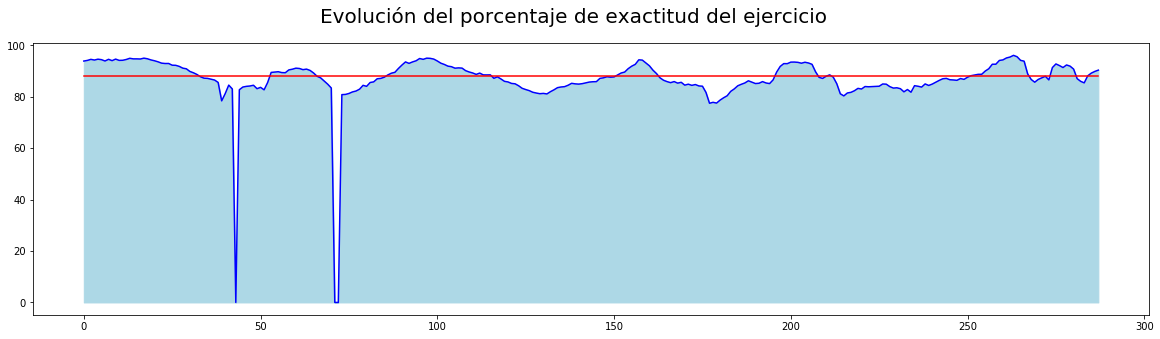

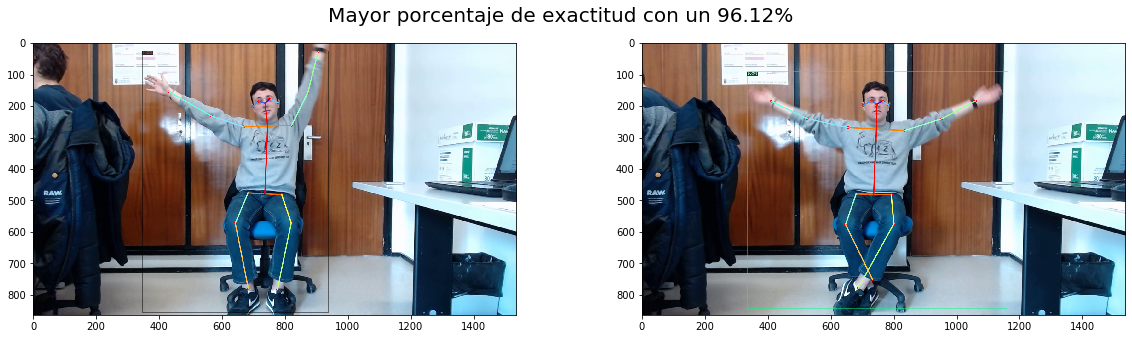

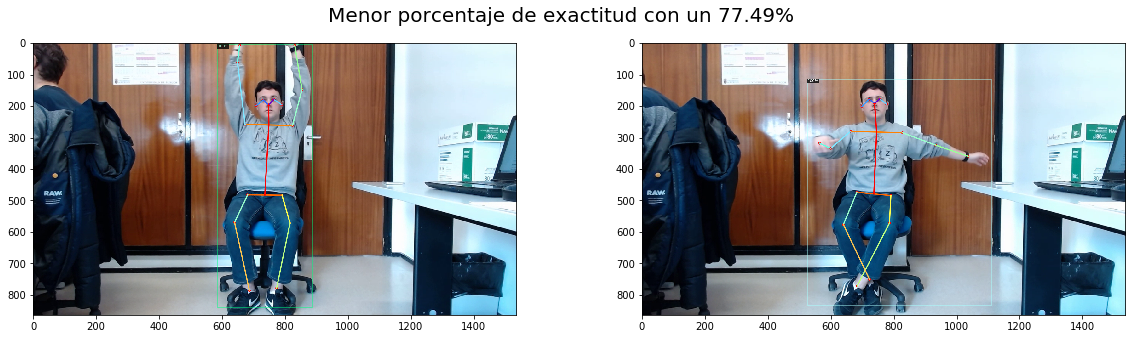

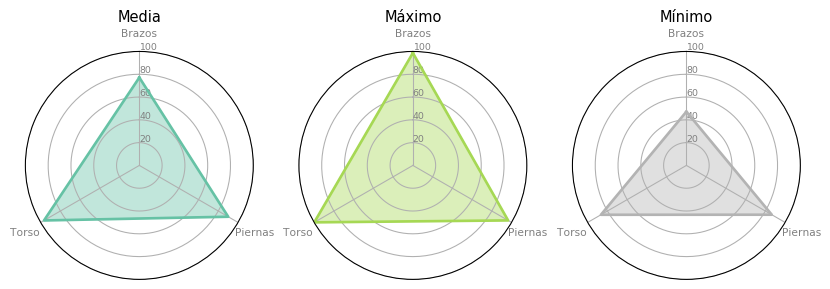

Comparación Brazos


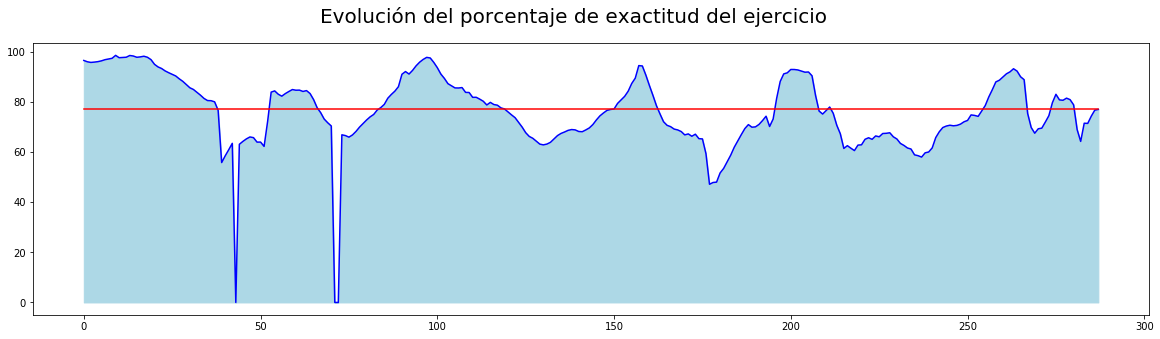

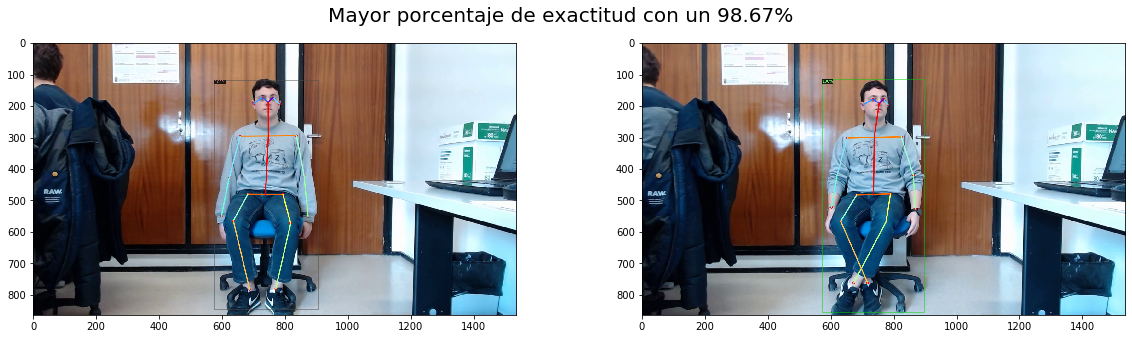

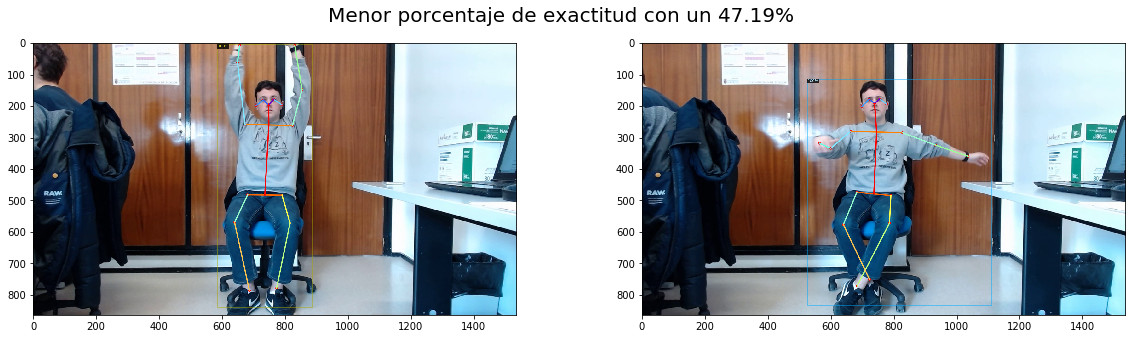

Comparación Piernas


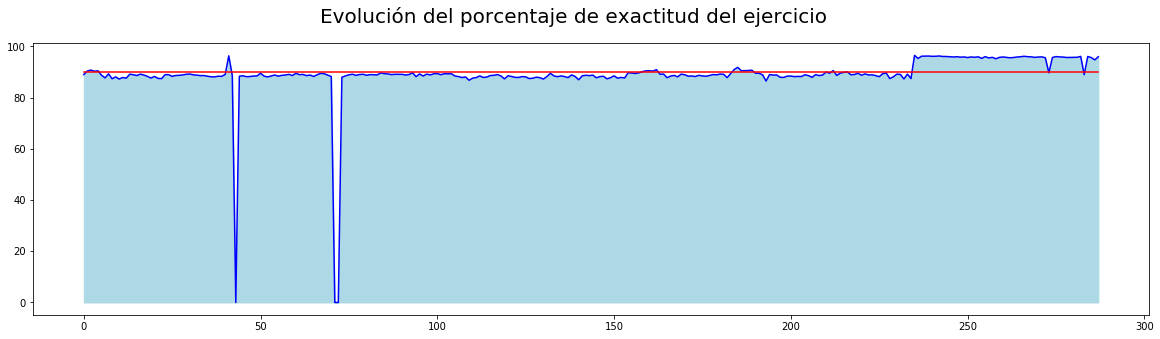

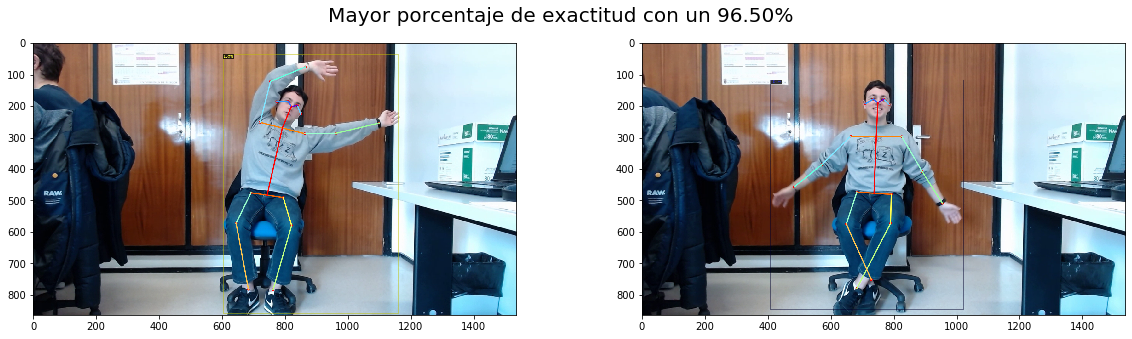

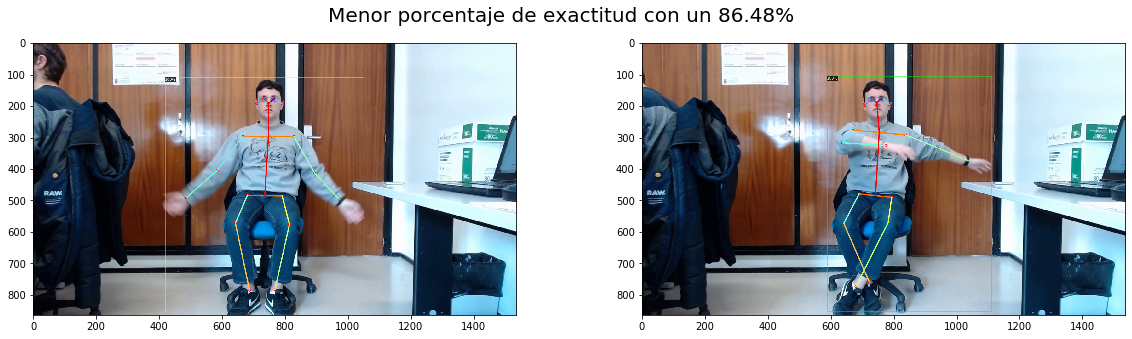

Comparación Torso


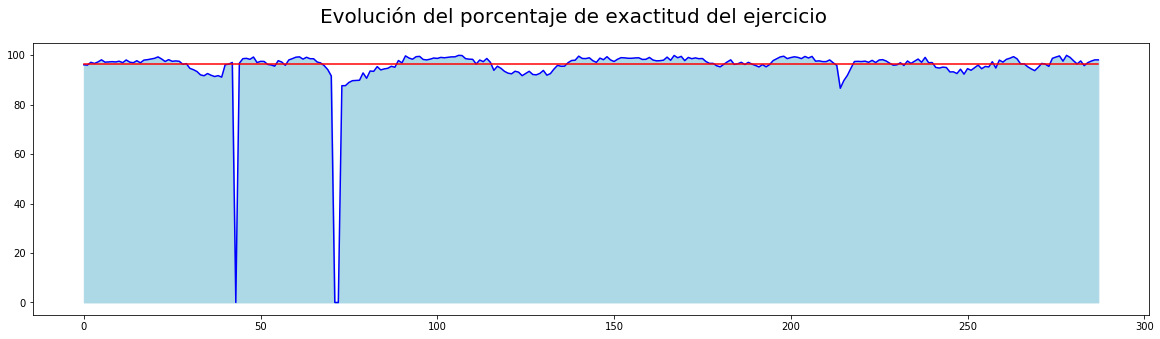

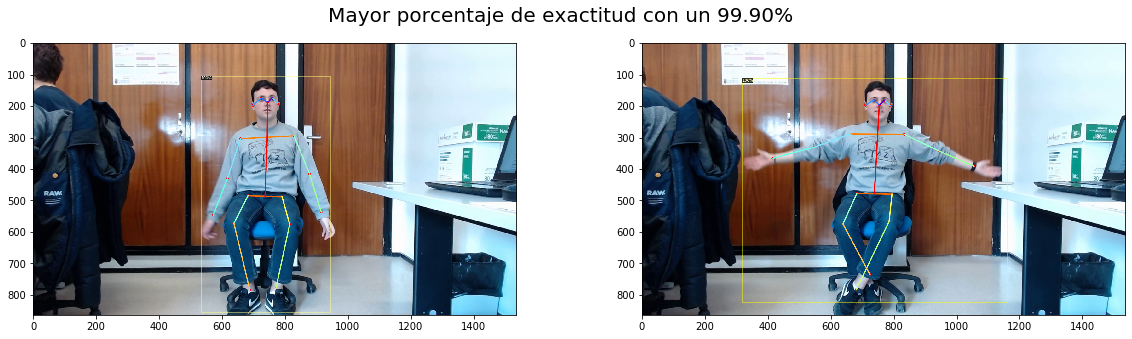

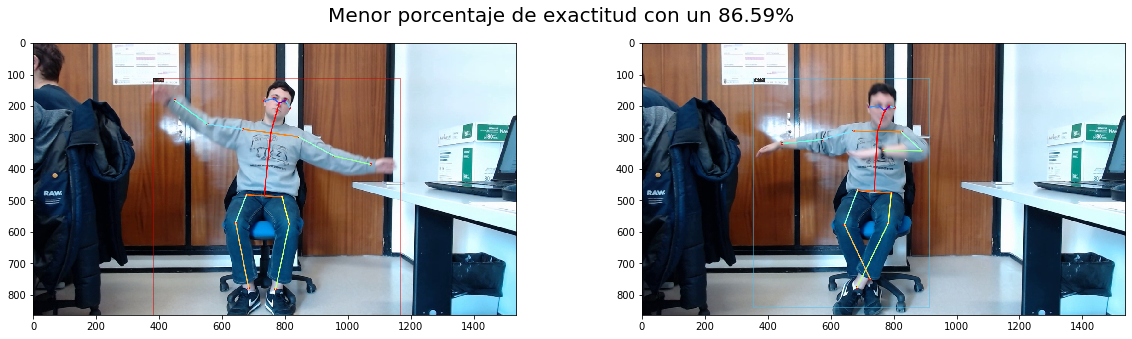

In [17]:
v = compararVideos('pruebas/videos-prueba/Videos/Josemi/sentado1.webm','pruebas/videos-prueba/Videos/Josemi/sentado2-cruzado.webm')